# Just a nice stacking ensemble model...

In [1]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

import xgboost as xgb

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline  

In [2]:
use_xgb=True #disable for speed

datadir="./input/"
cachedir="./cache/"
print(check_output(["ls", datadir]).decode("utf8"))
#print(check_output(["ls", cachedir]).decode("utf8"))



# XGB!

#my first tries:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}
#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}


test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
test_data_validation_train_all_features.csv
test_data_validation_train_cats.csv
test_data_validation_train_conts.csv
test_data_validation_train_new.csv
test_data_validation_train_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv
train_data_validation_train_all_features.csv
train_data_validation_train_cats.csv
train_data_validation_train_conts.csv
train_data_validation_train_new.csv
train_data_validation_train_orig_only.csv



In [3]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [4]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        print "load train"
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        print "load test"
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data

In [5]:

def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [6]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [7]:
def kmeansPlusmeanshift_quick(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [8]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

### Setup

In [41]:
shift=200

#Which dataset?
dataset='validation_train'
#dataset='final'

if dataset=='validation_train':
    data_name="validation_train_"+'all_features'  # against only local data
else:
    data_name='all_features' #for final data run for submissions to kaggle

x,y,test_data=prepdata(data_name,verbose=False)
x_test_data=test_data.drop(['loss','id'],1).values# didn't have the loss column before, make it go away! don't need ID!

loading: ./input/train_data_validation_train_all_features.csv
Dataset has 150654 samples with 135 features each.
loading: ./input/test_data_validation_train_all_features.csv
Dataset has 37664 samples with 135 features each.


In [43]:
display(test_data.head(3))

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont10,cont11,cont12,cont13,cont14,id,clusters,clusters_cont,clusters_cat,loss
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.897902,0.731279,0.759270,-0.079028,0.988583,32206,0.721519,0.177215,0.392405,1550.79
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.716721,0.829973,0.821559,-0.218555,0.988603,22084,0.886076,0.265823,0.556962,1042.49
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.758027,0.688640,0.680098,-1.060718,0.999097,123866,0.974684,0.835443,0.177215,5415.68


In [11]:
#prepare the fold divisions --should move this somewhere else...should we make an effort to keep consistent in each file?

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 150654
folds at: [(0, 30130), (30130, 60260), (60260, 90390), (90390, 120520), (120520, 150654)]
fold size: 30130
train size: 120520
150654


### load layer 1 results

In [12]:
#load the results from JustStacking-Layer1.ipynb
if dataset=='validation_train':
    x_layer2=joblib.load(cachedir+'x_layer2_train_validation.npy') 
else:
    x_layer2=joblib.load(cachedir+'x_layer2_train_final.npy') 


### train layer 2

In [15]:
# grid search on layer 2

start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl  exists, importing 
Full GridSearch run time:0.022s


In [16]:
dtrain = xgb.DMatrix(x_layer2, label=y)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
print("best_nrounds:",best_nrounds)

[0]	train-mae:7.2267+0.00177671	test-mae:7.2267+0.00534828
[100]	train-mae:2.64561+0.000655077	test-mae:2.64561+0.00346011
[200]	train-mae:0.979477+0.000410911	test-mae:0.980512+0.00324137
[300]	train-mae:0.469745+0.000566192	test-mae:0.478963+0.00244189
[400]	train-mae:0.371279+0.000826144	test-mae:0.388058+0.00185413
[500]	train-mae:0.353543+0.000837212	test-mae:0.375068+0.00157158
[600]	train-mae:0.348351+0.000949227	test-mae:0.373308+0.00142673
[700]	train-mae:0.345363+0.00128099	test-mae:0.37309+0.00137395
[800]	train-mae:0.342996+0.00143682	test-mae:0.373083+0.00133654
CV time:191.084s
CV-Mean: 0.37307275+0.00134806646257
('best_nrounds:', 761)


In [17]:
display(layer2_Lin_regr)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
          weights='uniform')

In [18]:
x_layer3 = []
MAE_tracking=[]
fold_counter=0

for fold_start,fold_end in folds:
    
    print("Fold {} of {} : {} to {} of: {}".format(fold_counter+1,num_folds,fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    fold_counter+=1
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_linear) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_KNeighbors) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('KNNLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_train, label=y_layer2_train)
    dtest = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)
    
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtest)
    #MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_gbdt_predict) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    #MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_avg_predict) - np.exp(y_layer2_validation)))

    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold 1 of 5 : 0 to 30130 of: 150654

folding! len test 30130, len train 120524
LinearRegression Mean abs error: 1153.48
Score: -51852571643867.48
KNeighborsRegressor Mean abs error: 1439.32
Score: 0.36
XGB Mean abs error: 1155.82
XGB predict time:0.173s
AVG Mean abs error: 1187.78
Fold 2 of 5 : 30130 to 60260 of: 150654

folding! len test 30130, len train 120524
LinearRegression Mean abs error: 1143.75
Score: 0.56
KNeighborsRegressor Mean abs error: 1446.40
Score: 0.34
XGB Mean abs error: 1144.35
XGB predict time:0.174s
AVG Mean abs error: 1179.17
Fold 3 of 5 : 60260 to 90390 of: 150654

folding! len test 30130, len train 120524


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:71: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


LinearRegression Mean abs error: 1165.86
Score: 0.58
KNeighborsRegressor Mean abs error: 1476.92
Score: 0.35
XGB Mean abs error: 1169.15
XGB predict time:0.182s
AVG Mean abs error: 1208.13
Fold 4 of 5 : 90390 to 120520 of: 150654

folding! len test 30130, len train 120524
LinearRegression Mean abs error: 1135.05
Score: 0.57
KNeighborsRegressor Mean abs error: 1431.65
Score: 0.35
XGB Mean abs error: 1138.03
XGB predict time:0.179s
AVG Mean abs error: 1169.50
Fold 5 of 5 : 120520 to 150654 of: 150654

folding! len test 30134, len train 120520
LinearRegression Mean abs error: 1137.07
Score: 0.57
KNeighborsRegressor Mean abs error: 1416.62
Score: 0.36
XGB Mean abs error: 1139.56
XGB predict time:0.188s
AVG Mean abs error: 1168.06


### Layer 3

In [19]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [20]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_train, label=y_layer3_train)
dtest = xgb.DMatrix(X_layer3_validation)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
print("best_nrounds:",best_nrounds)


layer3_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)


# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtest)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE=np.mean(abs(np.exp(layer3_gbdt_predict) - np.exp(y_layer3_validation)))
MAE_tracking.append(["run:{}".format('XGBLayer3'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

150654
150654
[0]	train-mae:7.22604+0.00230809	test-mae:7.22604+0.00697314
[100]	train-mae:2.6454+0.000841019	test-mae:2.64533+0.00617388
[200]	train-mae:0.979796+0.000404915	test-mae:0.979958+0.0054272
[300]	train-mae:0.480689+0.000336588	test-mae:0.483046+0.00196034
[400]	train-mae:0.38838+0.000344898	test-mae:0.393433+0.00194865
[500]	train-mae:0.373221+0.000381034	test-mae:0.380145+0.00210777
[600]	train-mae:0.369389+0.00040496	test-mae:0.377933+0.00216266
[700]	train-mae:0.36731+0.000392285	test-mae:0.377257+0.0021307
[800]	train-mae:0.365643+0.000337509	test-mae:0.376883+0.00214417
[900]	train-mae:0.364181+0.000371399	test-mae:0.376588+0.00211904
[1000]	train-mae:0.362821+0.000400225	test-mae:0.376375+0.00208728
[1100]	train-mae:0.361586+0.0004322	test-mae:0.376217+0.00205505
[1200]	train-mae:0.360433+0.000420697	test-mae:0.376076+0.00202906
[1300]	train-mae:0.359359+0.000436448	test-mae:0.375955+0.00198939
[1400]	train-mae:0.358363+0.000480391	test-mae:0.375877+0.00197057
[1500]

### MAE tracking:

[['run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:XGBLayer3']
 ['1153.4832395' '1439.32094101' '1155.81509104' '1143.75000959'
  '1446.40153477' '1144.3503653' '1165.85777199' '1476.92096553'
  '1169.15408857' '1135.05137382' '1431.65214015' '1138.02958611'
  '1137.06587349' '1416.61513966' '1139.5648809' '1169.22783666']]


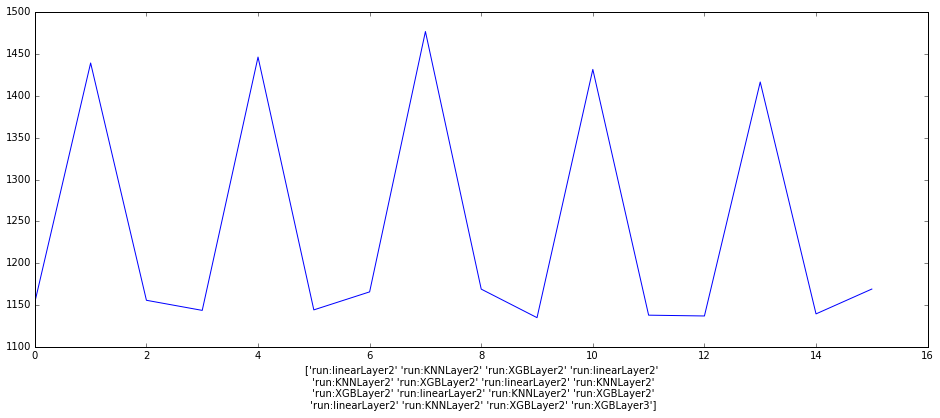

In [21]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)
plt.figure(figsize=(16,6))
plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [22]:
#load the results from JustStacking-Layer1.ipynb


if dataset=='validation_train':
    x_layer2_test=joblib.load(cachedir+'x_layer2_test_validation.npy' ) 
else:
    x_layer2_test=joblib.load(cachedir+'x_layer2_test_final.npy' ) 


### Layer 2 predictions!

In [60]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



Linear predict time:0.006s
KNeighbors predict time:5.748s
XGB predict time:0.266s
AVG predict time:0.001s


In [61]:
#spit out that good scoring linear result...
test_data['newloss_lin']=np.exp(layer3_predict_linear)-200

result_lin=test_data[['id','newloss_lin',]]

output_fname_lin="result_submission_stack_linear.csv"
display(writeData(result_lin.rename(index=str, columns={"newloss_lin": "loss"}),output_fname_lin))

['id,loss\n',
 '32206,1671.12980967\n',
 '22084,1180.53509679\n',
 '123866,3168.28254011\n',
 '125674,2621.03863089\n']

In [59]:
# if we are doing the validation set run, let load up it's reality:
if dataset=='validation_train':
    original_loss=test_data['loss']
    print("original: mean value:{}".format(np.mean(original_loss)))
    print("predicted: mean value:{}".format(np.mean(result['newloss_lin'])))
    MAE=np.mean(abs( result_lin['newloss_lin']-  original_loss ))
    print("final loss:{}\n".format(MAE))

original: mean value:3028.16216599
predicted: mean value:2688.36178861
final loss:1132.01294269



### Predict Layer 3

In [62]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['newloss_xgb']=np.exp(layer3_gbdt.predict(dtest))-200

result_xgb=test_data[['id','newloss_xgb',]]
output_fname_xgb="result_submission_stack_xgb.csv"
display(writeData(result_xgb.rename(index=str, columns={"newloss_xgb": "loss"}),output_fname_xgb))


['id,loss\n',
 '32206,1665.4251709\n',
 '22084,1113.35253906\n',
 '123866,3355.30493164\n',
 '125674,2990.984375\n']

In [63]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id         169410.403249
newloss      1978.943442
dtype: float64)


In [57]:
# if we are doing the validation set run, let load up it's reality:
if dataset=='validation_train':
    original_loss=test_data['loss']
    print("original: mean value:{}".format(np.mean(original_loss)))
    print("predicted: mean value:{}".format(np.mean(result_xgb['newloss_xgb'])))
    MAE=np.mean(abs(result_xgb['newloss_xgb'] -  original_loss))
    print("final loss:{}\n".format(MAE))

original: mean value:3028.16216599
predicted: mean value:2639.56152344
final loss:1154.27078252



# EOF 